In [1]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
import os
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
def is_valid_smiles(smiles):
    """Проверка валидности SMILES строки"""
    try:
        mol = Chem.MolFromSmiles(smiles)
        return mol is not None
    except:
        return False

In [3]:
MAX_LEN = 64
BATCH_SIZE = 128
EMB_DIM = 128
LATENT_DIM = 64
FF_DIM = 256
N_HEADS = 8
NUM_LAYERS = 2
VOCAB_SPECIAL = ['<pad>', '<bos>', '<eos>', '<unk>']
DROPOUT = 0.1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используем устройство: {device}")
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.cuda.get_device_name(0))

Используем устройство: cuda
True
11.8
NVIDIA GeForce RTX 4050 Laptop GPU


In [4]:
# Загрузка и подготовка данных
df = pd.read_csv("polymer_bigdata_merged.csv")
df = df.dropna(subset=["polymer_smiles"])

NUM_FEATURES = [
    "Enthalpy of Polymerization (kJ/mol)",
    "Glass Transition Temperature (K)",
    "Specific Heat Capacity (J {gK}^{-1})",
    "Tensile Strength at break (MPa)",
    "Thermal Decomposition Temperature (K)",
    "Youngs Modulus (GPa)"
]

In [5]:
scaler = MinMaxScaler()
df[NUM_FEATURES] = scaler.fit_transform(df[NUM_FEATURES])

In [6]:
def tokenize(smiles):
    """Токенизация SMILES строки"""
    return list(smiles)

all_tokens = set()
for s in df["polymer_smiles"]:
    all_tokens.update(tokenize(s))

tokens = VOCAB_SPECIAL + sorted(list(all_tokens))
token2idx = {t: i for i, t in enumerate(tokens)}
idx2token = {i: t for t, i in token2idx.items()}
vocab_size = len(token2idx)
print(f"Размер словаря: {vocab_size}")

Размер словаря: 52


In [7]:
class ImprovedConditionalSMILESDataset(Dataset):
    def __init__(self, dataframe, max_len=MAX_LEN):
        self.data = dataframe["polymer_smiles"].tolist()
        self.features = dataframe[NUM_FEATURES].values.astype(np.float32)
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def encode_smiles(self, smiles):
        """Кодирование SMILES в последовательность токенов"""
        tokens = ['<bos>'] + tokenize(smiles) + ['<eos>']
        if len(tokens) > self.max_len:
            tokens = tokens[:self.max_len-1] + ['<eos>']
        
        token_ids = [token2idx.get(t, token2idx['<unk>']) for t in tokens]
        padding = [token2idx['<pad>']] * (self.max_len - len(token_ids))
        return torch.tensor(token_ids + padding)

    def __getitem__(self, idx):
        x = self.encode_smiles(self.data[idx])
        tgt_input = x[:-1]
        tgt_output = x[1:]
        feats = torch.tensor(self.features[idx])
        return tgt_input, tgt_output, feats

In [8]:
class ImprovedConditionalTransformerVAE(nn.Module):
    def __init__(self, vocab_size, emb_dim, latent_dim, num_heads, ff_dim, num_layers, max_len, feature_dim, dropout=0.1):
        super().__init__()
        self.emb_dim = emb_dim
        self.latent_dim = latent_dim
        self.max_len = max_len

        # Embedding слои
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=token2idx['<pad>'])
        self.pos_emb = nn.Parameter(torch.randn(1, max_len, emb_dim))
        self.dropout = nn.Dropout(dropout)

        # Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=emb_dim, 
            nhead=num_heads, 
            dim_feedforward=ff_dim, 
            dropout=dropout,
            batch_first=False,
            activation='gelu'
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Feature encoder
        self.feat_encoder = nn.Sequential(
            nn.Linear(feature_dim, latent_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(latent_dim, latent_dim)
        )

        # Latent projection
        self.fc_mu = nn.Linear(emb_dim + latent_dim, latent_dim)
        self.fc_logvar = nn.Linear(emb_dim + latent_dim, latent_dim)

        # Decoder projection
        self.latent_to_emb = nn.Sequential(
            nn.Linear(latent_dim * 2, emb_dim),
            nn.GELU(),
            nn.Dropout(dropout)
        )

        # Decoder
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=emb_dim,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=False,
            activation='gelu'
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        
        # Output layer
        self.out = nn.Linear(emb_dim, vocab_size)

        # Инициализация весов
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0, std=0.02)

    def encode(self, src, feats):
        """Кодирование входной последовательности и признаков в латентное пространство"""
        src_mask = (src == token2idx['<pad>']).bool()
        src_emb = self.emb(src) + self.pos_emb[:, :src.size(1)]
        src_emb = self.dropout(src_emb)
        
        # Transformer encoder ожидает [S, B, E]
        src_emb = src_emb.transpose(0, 1)
        src_enc = self.encoder(src_emb, src_key_padding_mask=src_mask)
        
        # Используем mean pooling вместо первого токена
        cls_token = src_enc.mean(dim=0)  # [B, emb_dim]
        
        # Кодируем features
        feats_emb = self.feat_encoder(feats)  # [B, latent_dim]
        
        # Объединяем для получения латентных переменных
        combined = torch.cat([cls_token, feats_emb], dim=1)  # [B, emb_dim + latent_dim]
        mu = self.fc_mu(combined)
        logvar = self.fc_logvar(combined)
        
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """Reparameterization trick"""
        logvar = torch.clamp(logvar, min=-10, max=10)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, feats, tgt_inp):
        tgt_key_padding_mask = (tgt_inp == token2idx['<pad>']).bool()
    
        feats_latent = self.feat_encoder(feats)
        combined_latent = torch.cat([z, feats_latent], dim=1)
        memory_vec = self.latent_to_emb(combined_latent)
        
        # ⭐⭐⭐ ИСПРАВЛЕНИЕ: memory должна быть [S, B, E] где S = длина последовательности
        memory = memory_vec.unsqueeze(0)  # [1, B, E]
        # НЕ повторяем по времени здесь - decoder сам обработает
        
        tgt_emb = self.emb(tgt_inp) + self.pos_emb[:, :tgt_inp.size(1)]
        tgt_emb = self.dropout(tgt_emb)
        tgt_emb = tgt_emb.transpose(0, 1)  # [T, B, E]
        
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt_inp.size(1)).to(tgt_inp.device)
        
        out = self.decoder(
            tgt=tgt_emb,
            memory=memory,  # [1, B, E] - decoder сам расширит если нужно
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_key_padding_mask
        )
        
        logits = self.out(out.transpose(0, 1))
        return logits

    def forward(self, src, feats, tgt_inp):
        mu, logvar = self.encode(src, feats)
        z = self.reparameterize(mu, logvar)
        logits = self.decode(z, feats, tgt_inp)
        return logits, mu, logvar

In [9]:
def improved_vae_loss(logits, targets, mu, logvar, kl_weight=1.0, current_epoch=0, max_epochs=20):
    """Улучшенная функция потерь VAE с аннеалингом"""
    recon_loss = F.cross_entropy(
        logits.view(-1, logits.size(-1)), 
        targets.view(-1), 
        ignore_index=token2idx['<pad>'],
        label_smoothing=0.1
    )
    
    kl_loss = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
    
    # Увеличиваем kl_weight от 0 до 1 в течение эпох
    if current_epoch < max_epochs:
        annealing_factor = min(1.0, (current_epoch + 1) / (max_epochs * 0.5))  # плавный рост
        kl_weight = kl_weight * annealing_factor
    
    total_loss = recon_loss + kl_weight * kl_loss
    return total_loss, recon_loss, kl_loss

In [10]:
def generate_smiles_conditional_improved(model, target_feats, num_samples=5, temperature=0.7, max_length=MAX_LEN):
    """Улучшенная генерация SMILES с фильтрацией токенов"""
    model.eval()
    with torch.no_grad():
        device = next(model.parameters()).device
        
        if not target_feats.is_cuda:
            target_feats = target_feats.to(device)
            
        if target_feats.size(0) == 1:
            target_feats = target_feats.repeat(num_samples, 1)
        elif target_feats.size(0) < num_samples:
            target_feats = target_feats[:num_samples]
        elif target_feats.size(0) > num_samples:
            target_feats = target_feats[:num_samples]
        
        actual_num_samples = target_feats.size(0)
        
        # Генерируем латентный вектор
        z = torch.randn(actual_num_samples, model.latent_dim).to(device)
        
        # Кодируем features
        feats_latent = model.feat_encoder(target_feats)
        
        # Объединяем для создания memory
        combined_latent = torch.cat([z, feats_latent], dim=1)
        memory_vec = model.latent_to_emb(combined_latent)
        memory = memory_vec.unsqueeze(0)
        
        # Начальный токен
        sequences = torch.tensor([token2idx['<bos>']] * actual_num_samples, device=device).unsqueeze(1)
        finished = torch.zeros(actual_num_samples, dtype=torch.bool, device=device)
        
        for step in range(max_length - 1):
            tgt_emb = model.emb(sequences) + model.pos_emb[:, :sequences.size(1)]
            tgt_emb = tgt_emb.transpose(0, 1)
            
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(sequences.size(1)).to(device)
            
            out = model.decoder(tgt_emb, memory.repeat(sequences.size(1), 1, 1), tgt_mask=tgt_mask)
            logits = model.out(out.transpose(0, 1))[:, -1] / temperature
            
            # ⭐⭐⭐ УЛУЧШЕННАЯ МАСКА: более строгая фильтрация ⭐⭐⭐
            logits[:, token2idx['<pad>']] = -float('inf')
            logits[:, token2idx['<bos>']] = -float('inf')
            logits[:, token2idx['<unk>']] = -float('inf')
            
            # Маска для редких/проблемных символов
            problem_tokens = ['p', '9', '@', '?', '!', '$', '%', '&', '*', '+', ';', ':', '"', "'"]
            for problem_token in problem_tokens:
                if problem_token in token2idx:
                    logits[:, token2idx[problem_token]] = -float('inf')
            
            # ⭐⭐⭐ TOP-K ФИЛЬТРАЦИЯ ⭐⭐⭐
            top_k = min(30, logits.size(-1))
            top_probs, top_indices = torch.topk(F.softmax(logits, dim=-1), top_k, dim=-1)
            
            # Сэмплируем из top-k
            next_token = torch.zeros(actual_num_samples, dtype=torch.long, device=device)
            for i in range(actual_num_samples):
                if not finished[i]:
                    sampled_idx = torch.multinomial(top_probs[i], 1)
                    next_token[i] = top_indices[i, sampled_idx]
            
            sequences = torch.cat([sequences, next_token.unsqueeze(1)], dim=1)
            
            finished = finished | (next_token == token2idx['<eos>'])
            if finished.all():
                break
        
        return decode_sequences_improved(sequences.cpu())

def decode_sequences_improved(sequences):
    """Улучшенное декодирование с балансировкой скобок"""
    smiles_list = []
    for seq in sequences:
        tokens = []
        open_brackets = 0
        
        for idx in seq[1:]:  # пропускаем <bos>
            token = idx2token[idx.item()]
            
            if token == '<eos>':
                break
                
            if token not in VOCAB_SPECIAL:
                # Балансируем скобки
                if token == '(':
                    open_brackets += 1
                elif token == ')':
                    if open_brackets > 0:
                        open_brackets -= 1
                    else:
                        continue  # пропускаем лишнюю закрывающую скобку
                
                tokens.append(token)
        
        # Добавляем недостающие закрывающие скобки
        while open_brackets > 0:
            tokens.append(')')
            open_brackets -= 1
        
        smiles = ''.join(tokens)
        
        # Простая очистка очевидных ошибок
        if '()' in smiles:
            smiles = smiles.replace('()', '')
        
        smiles_list.append(smiles)
    
    return smiles_list

In [11]:
def generate_and_display_improved(model, feats_tensor, num_samples=5, temperature=0.7):
    """Улучшенная генерация и визуализация"""
    model.eval()
    with torch.no_grad():
        if not feats_tensor.is_cuda:
            feats_tensor = feats_tensor.to(device)
            
        smiles_list = generate_smiles_conditional_improved(model, feats_tensor, num_samples=num_samples, temperature=temperature)
        
        print("Сгенерированные SMILES (улучшенные):")
        valid_smiles = []
        valid_mols = []
        
        for i, sm in enumerate(smiles_list):
            # Базовая проверка перед валидацией
            if len(sm) < 3 or sm.count('*') == len(sm):
                validity = "✗"
            else:
                is_valid = is_valid_smiles(sm)
                validity = "✓" if is_valid else "✗"
                if is_valid:
                    valid_smiles.append(sm)
                    valid_mols.append(Chem.MolFromSmiles(sm))
            
            print(f"{i+1}. {sm} {validity}")
        
        # Визуализация
        if valid_mols:
            img = Draw.MolsToGridImage(valid_mols, molsPerRow=min(3, len(valid_mols)), 
                                     subImgSize=(300, 300), 
                                     legends=[f"Valid {i+1}" for i in range(len(valid_mols))])
            display(img)
            validity_rate = len(valid_mols) / num_samples * 100
            print(f"Валидных молекул: {len(valid_mols)}/{num_samples} ({validity_rate:.1f}%)")
        else:
            print("Нет валидных молекул для отображения.")
            
        return len(valid_mols) / num_samples if num_samples > 0 else 0

In [17]:
def validate_model(model, val_loader, epoch):
    """Валидация модели"""
    model.eval()
    total_loss = 0
    total_recon = 0
    total_kl = 0
    
    with torch.no_grad():
        for tgt_inp, tgt_out, feats in val_loader:
            tgt_inp, tgt_out, feats = tgt_inp.to(device), tgt_out.to(device), feats.to(device)
            logits, mu, logvar = model(tgt_inp, feats, tgt_inp)
            loss, recon_loss, kl_loss = improved_vae_loss(logits, tgt_out, mu, logvar, current_epoch=epoch)
            
            total_loss += loss.item()
            total_recon += recon_loss.item()
            total_kl += kl_loss.item()
    
    avg_loss = total_loss / len(val_loader)
    avg_recon = total_recon / len(val_loader)
    avg_kl = total_kl / len(val_loader)
    
    #  ИСПРАВЛЕНИЕ: согласование размеров 
    validity = 0
    if epoch % 5 == 0:
        valid_count = 0
        total_count = 0
        # Быстрая проверка - берем 5 примеров и генерируем по 2 SMILES для каждого
        sample_feats = torch.tensor(val_df_limited[NUM_FEATURES].iloc[:5].values, dtype=torch.float32).to(device)
        
        # Генерируем по 2 SMILES для каждого из 5 примеров
        for i in range(5):
            single_feat = sample_feats[i:i+1]  # [1, feature_dim]
            generated = generate_smiles_conditional_improved(model, single_feat, num_samples=2)
            for sm in generated:
                total_count += 1
                if is_valid_smiles(sm):
                    valid_count += 1
        
        validity = valid_count / total_count if total_count > 0 else 0
    
    return avg_loss, avg_recon, avg_kl, validity

In [13]:
# Подготовка данных
# valid_mask = df["polymer_smiles"].apply(is_valid_smiles)
# df = df[valid_mask].reset_index(drop=True)
# print(f"После валидации SMILES осталось {len(df)} записей")

# Подготовка данных
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

# Берем первые 9000 из тренировочных и 1000 из валидационных
train_df_limited = train_df.head(9000).reset_index(drop=True)
val_df_limited = val_df.head(1000).reset_index(drop=True)

print(f"Тренировочные данные: {len(train_df_limited)} записей")
print(f"Валидационные данные: {len(val_df_limited)} записей")

train_dataset = ImprovedConditionalSMILESDataset(train_df_limited)
val_dataset = ImprovedConditionalSMILESDataset(val_df_limited)

# ⭐⭐⭐ ИСПРАВЛЕНИЕ: num_workers=0 для Jupyter ⭐⭐⭐
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)

print(f"Размер тренировочного датасета: {len(train_dataset)}")
print(f"Размер валидационного датасета: {len(val_dataset)}")

Тренировочные данные: 9000 записей
Валидационные данные: 1000 записей
Размер тренировочного датасета: 9000
Размер валидационного датасета: 1000


In [14]:
# Инициализация модели
model = ImprovedConditionalTransformerVAE(
    vocab_size=vocab_size,
    emb_dim=EMB_DIM,
    latent_dim=LATENT_DIM,
    num_heads=N_HEADS,
    ff_dim=FF_DIM,
    num_layers=NUM_LAYERS,
    max_len=MAX_LEN,
    feature_dim=len(NUM_FEATURES),
    dropout=DROPOUT
).to(device)

print(f"Модель создана: {sum(p.numel() for p in model.parameters()):,} параметров")

Модель создана: 729,908 параметров


In [15]:
# Оптимизатор и scheduler
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=1e-4, 
    weight_decay=0.01,
    betas=(0.9, 0.98)
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

In [18]:
# Обучение модели
EPOCHS = 30
CHECKPOINT_DIR = 'checkpoints_conditional_vae'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

train_losses, val_losses = [], []
train_recon, val_recon = [], []
train_kl, val_kl = [], []
validities = []

best_val_loss = float('inf')

for epoch in range(EPOCHS):
    # Тренировка
    model.train()
    total_train_loss = 0
    total_train_recon = 0
    total_train_kl = 0
    
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]")
    for tgt_inp, tgt_out, feats in train_bar:
        tgt_inp, tgt_out, feats = tgt_inp.to(device), tgt_out.to(device), feats.to(device)
        
        optimizer.zero_grad()
        logits, mu, logvar = model(tgt_inp, feats, tgt_inp)
        loss, recon_loss, kl_loss = improved_vae_loss(logits, tgt_out, mu, logvar, current_epoch=epoch, max_epochs=EPOCHS)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        total_train_loss += loss.item()
        total_train_recon += recon_loss.item()
        total_train_kl += kl_loss.item()
        
        train_bar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Recon': f'{recon_loss.item():.4f}', 
            'KL': f'{kl_loss.item():.4f}'
        })
    
    # Валидация
    avg_val_loss, avg_val_recon, avg_val_kl, validity = validate_model(model, val_loader, epoch)
    
    # Сохранение метрик
    avg_train_loss = total_train_loss / len(train_loader)
    avg_train_recon = total_train_recon / len(train_loader)
    avg_train_kl = total_train_kl / len(train_loader)
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_recon.append(avg_train_recon)
    val_recon.append(avg_val_recon)
    train_kl.append(avg_train_kl)
    val_kl.append(avg_val_kl)
    validities.append(validity)
    
    # Обновление scheduler
    scheduler.step()
    
    print(f"Epoch {epoch+1}/{EPOCHS}:")
    print(f"  Train - Loss: {avg_train_loss:.4f}, Recon: {avg_train_recon:.4f}, KL: {avg_train_kl:.4f}")
    print(f"  Val   - Loss: {avg_val_loss:.4f}, Recon: {avg_val_recon:.4f}, KL: {avg_val_kl:.4f}")
    print(f"  Validity: {validity:.2%}")
    print(f"  LR: {scheduler.get_last_lr()[0]:.2e}")
    
    # Сохранение лучшей модели
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'token2idx': token2idx,
            'scaler': scaler
        }, os.path.join(CHECKPOINT_DIR, 'best_model.pth'))
        print("  ✓ Сохранена лучшая модель")
    
    # # Генерация примеров каждые 5 эпох
    # if (epoch + 1) % 5 == 0:
    #     print("  Генерация примеров:")
    #     # ⭐⭐⭐ Берем один пример и генерируем несколько SMILES ⭐⭐⭐
    #     sample_feats = torch.tensor(val_df[NUM_FEATURES].iloc[:1].values, dtype=torch.float32).to(device)
    #     generate_and_display_smiles(model, sample_feats, num_samples=3, temperature=0.8)

Epoch 1/30 [Train]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:08<00:00,  8.47it/s, Loss=2.6453, Recon=2.6297, KL=0.2333]
[23:11:45] SMILES Parse Error: syntax error while parsing: [2]CC((CCS1C]C=(=)cC)c11(C)cc=ccccSc]2Oc2cCCCccnCcc)1CCC1
[23:11:45] SMILES Parse Error: check for mistakes around position 3:
[23:11:45] [2]CC((CCS1C]C=(=)cC)c11(C)cc=ccccSc]2Oc2
[23:11:45] ~~^
[23:11:45] SMILES Parse Error: Failed parsing SMILES '[2]CC((CCS1C]C=(=)cC)c11(C)cc=ccccSc]2Oc2cCCCccnCcc)1CCC1' for input: '[2]CC((CCS1C]C=(=)cC)c11(C)cc=ccccSc]2Oc2cCCCccnCcc)1CCC1'
[23:11:45] SMILES Parse Error: syntax error while parsing: [P]CCCCS(CCC[NCNcO=(CCC[cCCC](c))CCc=CC)c1Cc=[CC(cC)Ccc1
[23:11:45] SMILES Parse Error: check for mistakes around position 15:
[23:11:45] [P]CCCCS(CCC[NCNcO=(CCC[cCCC](c))CCc=CC)c
[23:11:45] ~~~~~~~~~~~~~~^
[23:11:45] SMILES Parse Error: Failed parsing SMILES '[P]CCCCS(CCC[N

Epoch 1/30:
  Train - Loss: 2.6842, Recon: 2.6664, KL: 0.2678
  Val   - Loss: 2.5805, Recon: 2.5773, KL: 0.0326
  Validity: 0.00%
  LR: 9.94e-05
  ✓ Сохранена лучшая модель


Epoch 2/30 [Train]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:08<00:00,  8.16it/s, Loss=2.5596, Recon=2.5375, KL=0.1658]


Epoch 2/30:
  Train - Loss: 2.6300, Recon: 2.6036, KL: 0.1981
  Val   - Loss: 2.5494, Recon: 2.5456, KL: 0.0186
  Validity: 0.00%
  LR: 9.76e-05
  ✓ Сохранена лучшая модель


Epoch 3/30 [Train]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:06<00:00, 10.98it/s, Loss=2.6486, Recon=2.6225, KL=0.1305]


Epoch 3/30:
  Train - Loss: 2.6059, Recon: 2.5766, KL: 0.1467
  Val   - Loss: 2.5325, Recon: 2.5286, KL: 0.0129
  Validity: 0.00%
  LR: 9.46e-05
  ✓ Сохранена лучшая модель


Epoch 4/30 [Train]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:07<00:00,  9.60it/s, Loss=2.5780, Recon=2.5517, KL=0.0984]


Epoch 4/30:
  Train - Loss: 2.5867, Recon: 2.5562, KL: 0.1143
  Val   - Loss: 2.5149, Recon: 2.5108, KL: 0.0104
  Validity: 0.00%
  LR: 9.05e-05
  ✓ Сохранена лучшая модель


Epoch 5/30 [Train]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:09<00:00,  7.56it/s, Loss=2.5759, Recon=2.5469, KL=0.0870]


Epoch 5/30:
  Train - Loss: 2.5670, Recon: 2.5357, KL: 0.0940
  Val   - Loss: 2.4828, Recon: 2.4790, KL: 0.0076
  Validity: 0.00%
  LR: 8.55e-05
  ✓ Сохранена лучшая модель


Epoch 6/30 [Train]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:09<00:00,  7.39it/s, Loss=2.4684, Recon=2.4393, KL=0.0727]
[23:12:34] SMILES Parse Error: syntax error while parsing: [l]CCNCCC]S(]O]cCcCCO)1(1CCN)CC=(Ccnc(O)c1cc1cn2c(C)ccc1)
[23:12:34] SMILES Parse Error: check for mistakes around position 2:
[23:12:34] [l]CCNCCC]S(]O]cCcCCO)1(1CCN)CC=(Ccnc(O)c
[23:12:34] ~^
[23:12:34] SMILES Parse Error: Failed parsing SMILES '[l]CCNCCC]S(]O]cCcCCO)1(1CCN)CC=(Ccnc(O)c1cc1cn2c(C)ccc1)' for input: '[l]CCNCCC]S(]O]cCcCCO)1(1CCN)CC=(Ccnc(O)c1cc1cn2c(C)ccc1)'
[23:12:34] non-ring atom 0 marked aromatic
[23:12:36] SMILES Parse Error: syntax error while parsing: [e]=CC(((S=C])((1)]CcOC(COCO)c(c)CCC)21ccCcc))
[23:12:36] SMILES Parse Error: check for mistakes around position 2:
[23:12:36] [e]=CC(((S=C])((1)]CcOC(COCO)c(c)CCC)21cc
[23:12:36] ~^
[23:12:36] SMILES Parse Error: Failed parsing SMIL

Epoch 6/30:
  Train - Loss: 2.5368, Recon: 2.5051, KL: 0.0791
  Val   - Loss: 2.4259, Recon: 2.4220, KL: 0.0064
  Validity: 0.00%
  LR: 7.96e-05
  ✓ Сохранена лучшая модель


Epoch 7/30 [Train]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:13<00:00,  5.40it/s, Loss=2.4608, Recon=2.4303, KL=0.0654]


Epoch 7/30:
  Train - Loss: 2.4955, Recon: 2.4633, KL: 0.0690
  Val   - Loss: 2.3403, Recon: 2.3367, KL: 0.0051
  Validity: 0.00%
  LR: 7.30e-05
  ✓ Сохранена лучшая модель


Epoch 8/30 [Train]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:09<00:00,  7.30it/s, Loss=2.4855, Recon=2.4541, KL=0.0588]


Epoch 8/30:
  Train - Loss: 2.4531, Recon: 2.4201, KL: 0.0619
  Val   - Loss: 2.2708, Recon: 2.2679, KL: 0.0036
  Validity: 0.00%
  LR: 6.58e-05
  ✓ Сохранена лучшая модель


Epoch 9/30 [Train]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:08<00:00,  8.66it/s, Loss=2.3974, Recon=2.3653, KL=0.0536]


Epoch 9/30:
  Train - Loss: 2.4138, Recon: 2.3803, KL: 0.0559
  Val   - Loss: 2.2139, Recon: 2.2105, KL: 0.0038
  Validity: 0.00%
  LR: 5.82e-05
  ✓ Сохранена лучшая модель


Epoch 10/30 [Train]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:07<00:00,  9.53it/s, Loss=2.4071, Recon=2.3705, KL=0.0548]


Epoch 10/30:
  Train - Loss: 2.3787, Recon: 2.3442, KL: 0.0517
  Val   - Loss: 2.1668, Recon: 2.1635, KL: 0.0033
  Validity: 0.00%
  LR: 5.05e-05
  ✓ Сохранена лучшая модель


Epoch 11/30 [Train]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:08<00:00,  8.04it/s, Loss=2.3897, Recon=2.3556, KL=0.0466]
[23:13:30] SMILES Parse Error: syntax error while parsing: [3]OCN(CC[[)C1CC(=Cccccn2)
[23:13:30] SMILES Parse Error: check for mistakes around position 3:
[23:13:30] [3]OCN(CC[[)C1CC(=Cccccn2)
[23:13:30] ~~^
[23:13:30] SMILES Parse Error: Failed parsing SMILES '[3]OCN(CC[[)C1CC(=Cccccn2)' for input: '[3]OCN(CC[[)C1CC(=Cccccn2)'
[23:13:30] SMILES Parse Error: syntax error while parsing: [-]CC(C(C(C(=([])ccC[C(=N2)(OCCO)(=CC)C)C=CM1c1S[=(C(])))))
[23:13:30] SMILES Parse Error: check for mistakes around position 2:
[23:13:30] [-]CC(C(C(C(=([])ccC[C(=N2)(OCCO)(=CC)C)C
[23:13:30] ~^
[23:13:30] SMILES Parse Error: Failed parsing SMILES '[-]CC(C(C(C(=([])ccC[C(=N2)(OCCO)(=CC)C)C=CM1c1S[=(C(])))))' for input: '[-]CC(C(C(C(=([])ccC[C(=N2)(OCCO)(=CC)C)C=CM1c1S[=(C(])))))'

Epoch 11/30:
  Train - Loss: 2.3496, Recon: 2.3142, KL: 0.0483
  Val   - Loss: 2.1288, Recon: 2.1257, KL: 0.0030
  Validity: 0.00%
  LR: 4.28e-05
  ✓ Сохранена лучшая модель


Epoch 12/30 [Train]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:11<00:00,  6.14it/s, Loss=2.3658, Recon=2.3308, KL=0.0437]


Epoch 12/30:
  Train - Loss: 2.3276, Recon: 2.2912, KL: 0.0456
  Val   - Loss: 2.1032, Recon: 2.1004, KL: 0.0027
  Validity: 0.00%
  LR: 3.52e-05
  ✓ Сохранена лучшая модель


Epoch 13/30 [Train]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:10<00:00,  6.88it/s, Loss=2.3406, Recon=2.3040, KL=0.0422]


Epoch 13/30:
  Train - Loss: 2.3055, Recon: 2.2680, KL: 0.0433
  Val   - Loss: 2.0813, Recon: 2.0785, KL: 0.0028
  Validity: 0.00%
  LR: 2.80e-05
  ✓ Сохранена лучшая модель


Epoch 14/30 [Train]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:09<00:00,  7.22it/s, Loss=2.2536, Recon=2.2153, KL=0.0410]


Epoch 14/30:
  Train - Loss: 2.2895, Recon: 2.2505, KL: 0.0418
  Val   - Loss: 2.0651, Recon: 2.0624, KL: 0.0028
  Validity: 0.00%
  LR: 2.14e-05
  ✓ Сохранена лучшая модель


Epoch 15/30 [Train]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:08<00:00,  8.71it/s, Loss=2.2213, Recon=2.1801, KL=0.0412]


Epoch 15/30:
  Train - Loss: 2.2781, Recon: 2.2376, KL: 0.0404
  Val   - Loss: 2.0535, Recon: 2.0508, KL: 0.0026
  Validity: 0.00%
  LR: 1.55e-05
  ✓ Сохранена лучшая модель


Epoch 16/30 [Train]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:10<00:00,  6.61it/s, Loss=2.2669, Recon=2.2273, KL=0.0396]
[23:14:26] SMILES Parse Error: syntax error while parsing: []]CCC(CC(C[])C(=O)N(OCC(CCCCC(=O)1c1([])C(O)C)))
[23:14:26] SMILES Parse Error: check for mistakes around position 2:
[23:14:26] []]CCC(CC(C[])C(=O)N(OCC(CCCCC(=O)1c1([])
[23:14:26] ~^
[23:14:26] SMILES Parse Error: Failed parsing SMILES '[]]CCC(CC(C[])C(=O)N(OCC(CCCCC(=O)1c1([])C(O)C)))' for input: '[]]CCC(CC(C[])C(=O)N(OCC(CCCCC(=O)1c1([])C(O)C)))'
[23:14:26] SMILES Parse Error: syntax error while parsing: [A]=C(=CC(O)O)N(=O)cc1cccc2ccn1C=cc(=CC)
[23:14:26] SMILES Parse Error: check for mistakes around position 2:
[23:14:26] [A]=C(=CC(O)O)N(=O)cc1cccc2ccn1C=cc(=CC)
[23:14:26] ~^
[23:14:26] SMILES Parse Error: Failed parsing SMILES '[A]=C(=CC(O)O)N(=O)cc1cccc2ccn1C=cc(=CC)' for input: '[A]=C(=CC(O)O)N(

Epoch 16/30:
  Train - Loss: 2.2688, Recon: 2.2293, KL: 0.0396
  Val   - Loss: 2.0450, Recon: 2.0429, KL: 0.0021
  Validity: 0.00%
  LR: 1.05e-05
  ✓ Сохранена лучшая модель


Epoch 17/30 [Train]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:10<00:00,  6.93it/s, Loss=2.2673, Recon=2.2284, KL=0.0388]


Epoch 17/30:
  Train - Loss: 2.2605, Recon: 2.2217, KL: 0.0388
  Val   - Loss: 2.0403, Recon: 2.0381, KL: 0.0021
  Validity: 0.00%
  LR: 6.40e-06
  ✓ Сохранена лучшая модель


Epoch 18/30 [Train]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:08<00:00,  7.93it/s, Loss=2.3040, Recon=2.2658, KL=0.0382]


Epoch 18/30:
  Train - Loss: 2.2568, Recon: 2.2184, KL: 0.0383
  Val   - Loss: 2.0378, Recon: 2.0356, KL: 0.0022
  Validity: 0.00%
  LR: 3.42e-06
  ✓ Сохранена лучшая модель


Epoch 19/30 [Train]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:09<00:00,  7.76it/s, Loss=2.1992, Recon=2.1598, KL=0.0394]


Epoch 19/30:
  Train - Loss: 2.2523, Recon: 2.2143, KL: 0.0380
  Val   - Loss: 2.0359, Recon: 2.0339, KL: 0.0020
  Validity: 0.00%
  LR: 1.61e-06
  ✓ Сохранена лучшая модель


Epoch 20/30 [Train]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:08<00:00,  8.46it/s, Loss=2.2681, Recon=2.2317, KL=0.0364]


Epoch 20/30:
  Train - Loss: 2.2536, Recon: 2.2158, KL: 0.0378
  Val   - Loss: 2.0344, Recon: 2.0324, KL: 0.0020
  Validity: 0.00%
  LR: 1.00e-06
  ✓ Сохранена лучшая модель


Epoch 21/30 [Train]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:10<00:00,  7.02it/s, Loss=2.1921, Recon=2.1539, KL=0.0382]
[23:15:23] SMILES Parse Error: syntax error while parsing: [I]=CC1C(Cn(C)C(O)C(=O)Ncccccncc2c1(==C[)ccc(C(Cccccc1)C))
[23:15:23] SMILES Parse Error: check for mistakes around position 38:
[23:15:23] )C(=O)Ncccccncc2c1(==C[)ccc(C(Cccccc1)C))
[23:15:23] ~~~~~~~~~~~~~~~~~~~~^
[23:15:23] SMILES Parse Error: Failed parsing SMILES '[I]=CC1C(Cn(C)C(O)C(=O)Ncccccncc2c1(==C[)ccc(C(Cccccc1)C))' for input: '[I]=CC1C(Cn(C)C(O)C(=O)Ncccccncc2c1(==C[)ccc(C(Cccccc1)C))'
[23:15:23] SMILES Parse Error: syntax error while parsing: [I]=CNNCCC(==O)(=OC(=O)CNC)cc(=[)CCC[(CC)OC3CCcc1C
[23:15:23] SMILES Parse Error: check for mistakes around position 13:
[23:15:23] [I]=CNNCCC(==O)(=OC(=O)CNC)cc(=[)CCC[(CC)
[23:15:23] ~~~~~~~~~~~~^
[23:15:23] SMILES Parse Error: Failed parsing SMILES '

Epoch 21/30:
  Train - Loss: 2.2502, Recon: 2.2126, KL: 0.0376
  Val   - Loss: 2.0347, Recon: 2.0326, KL: 0.0020
  Validity: 0.00%
  LR: 1.61e-06


Epoch 22/30 [Train]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:08<00:00,  8.44it/s, Loss=2.2743, Recon=2.2363, KL=0.0379]


Epoch 22/30:
  Train - Loss: 2.2520, Recon: 2.2143, KL: 0.0377
  Val   - Loss: 2.0335, Recon: 2.0315, KL: 0.0020
  Validity: 0.00%
  LR: 3.42e-06
  ✓ Сохранена лучшая модель


Epoch 23/30 [Train]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:09<00:00,  7.29it/s, Loss=2.2603, Recon=2.2227, KL=0.0376]


Epoch 23/30:
  Train - Loss: 2.2496, Recon: 2.2119, KL: 0.0377
  Val   - Loss: 2.0319, Recon: 2.0299, KL: 0.0020
  Validity: 0.00%
  LR: 6.40e-06
  ✓ Сохранена лучшая модель


Epoch 24/30 [Train]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:08<00:00,  8.10it/s, Loss=2.2572, Recon=2.2197, KL=0.0375]


Epoch 24/30:
  Train - Loss: 2.2477, Recon: 2.2105, KL: 0.0372
  Val   - Loss: 2.0294, Recon: 2.0275, KL: 0.0020
  Validity: 0.00%
  LR: 1.05e-05
  ✓ Сохранена лучшая модель


Epoch 25/30 [Train]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:07<00:00,  9.50it/s, Loss=2.2543, Recon=2.2163, KL=0.0380]


Epoch 25/30:
  Train - Loss: 2.2431, Recon: 2.2060, KL: 0.0371
  Val   - Loss: 2.0253, Recon: 2.0232, KL: 0.0021
  Validity: 0.00%
  LR: 1.55e-05
  ✓ Сохранена лучшая модель


Epoch 26/30 [Train]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:07<00:00,  9.25it/s, Loss=2.2031, Recon=2.1663, KL=0.0368]
[23:16:13] SMILES Parse Error: syntax error while parsing: [8]CCN(CC(CC[])N(O)(=C(NCC(C)cc2)cc(Cc1)F)CCcc1(C=O))
[23:16:13] SMILES Parse Error: check for mistakes around position 3:
[23:16:13] [8]CCN(CC(CC[])N(O)(=C(NCC(C)cc2)cc(Cc1)F
[23:16:13] ~~^
[23:16:13] SMILES Parse Error: Failed parsing SMILES '[8]CCN(CC(CC[])N(O)(=C(NCC(C)cc2)cc(Cc1)F)CCcc1(C=O))' for input: '[8]CCN(CC(CC[])N(O)(=C(NCC(C)cc2)cc(Cc1)F)CCcc1(C=O))'
[23:16:13] SMILES Parse Error: syntax error while parsing: [3]CCCC(CC([])(CCCC(C([])CCc(C)ccc1cc1(OCn1H1)C)CCC(C)C))
[23:16:13] SMILES Parse Error: check for mistakes around position 3:
[23:16:13] [3]CCCC(CC([])(CCCC(C([])CCc(C)ccc1cc1(OC
[23:16:13] ~~^
[23:16:13] SMILES Parse Error: Failed parsing SMILES '[3]CCCC(CC([])(CCCC(C([])CCc(C)ccc1cc1

Epoch 26/30:
  Train - Loss: 2.2366, Recon: 2.2002, KL: 0.0364
  Val   - Loss: 2.0183, Recon: 2.0164, KL: 0.0019
  Validity: 10.00%
  LR: 2.14e-05
  ✓ Сохранена лучшая модель


Epoch 27/30 [Train]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:10<00:00,  6.49it/s, Loss=2.2698, Recon=2.2351, KL=0.0347]


Epoch 27/30:
  Train - Loss: 2.2288, Recon: 2.1932, KL: 0.0357
  Val   - Loss: 2.0113, Recon: 2.0091, KL: 0.0022
  Validity: 0.00%
  LR: 2.80e-05
  ✓ Сохранена лучшая модель


Epoch 28/30 [Train]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:11<00:00,  6.34it/s, Loss=2.1897, Recon=2.1547, KL=0.0349]


Epoch 28/30:
  Train - Loss: 2.2130, Recon: 2.1781, KL: 0.0349
  Val   - Loss: 2.0001, Recon: 1.9979, KL: 0.0022
  Validity: 0.00%
  LR: 3.52e-05
  ✓ Сохранена лучшая модель


Epoch 29/30 [Train]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:10<00:00,  6.92it/s, Loss=2.1888, Recon=2.1537, KL=0.0351]


Epoch 29/30:
  Train - Loss: 2.1985, Recon: 2.1648, KL: 0.0337
  Val   - Loss: 1.9864, Recon: 1.9845, KL: 0.0019
  Validity: 0.00%
  LR: 4.28e-05
  ✓ Сохранена лучшая модель


Epoch 30/30 [Train]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:09<00:00,  7.39it/s, Loss=2.2132, Recon=2.1812, KL=0.0320]


Epoch 30/30:
  Train - Loss: 2.1809, Recon: 2.1485, KL: 0.0324
  Val   - Loss: 1.9746, Recon: 1.9728, KL: 0.0017
  Validity: 0.00%
  LR: 5.05e-05
  ✓ Сохранена лучшая модель


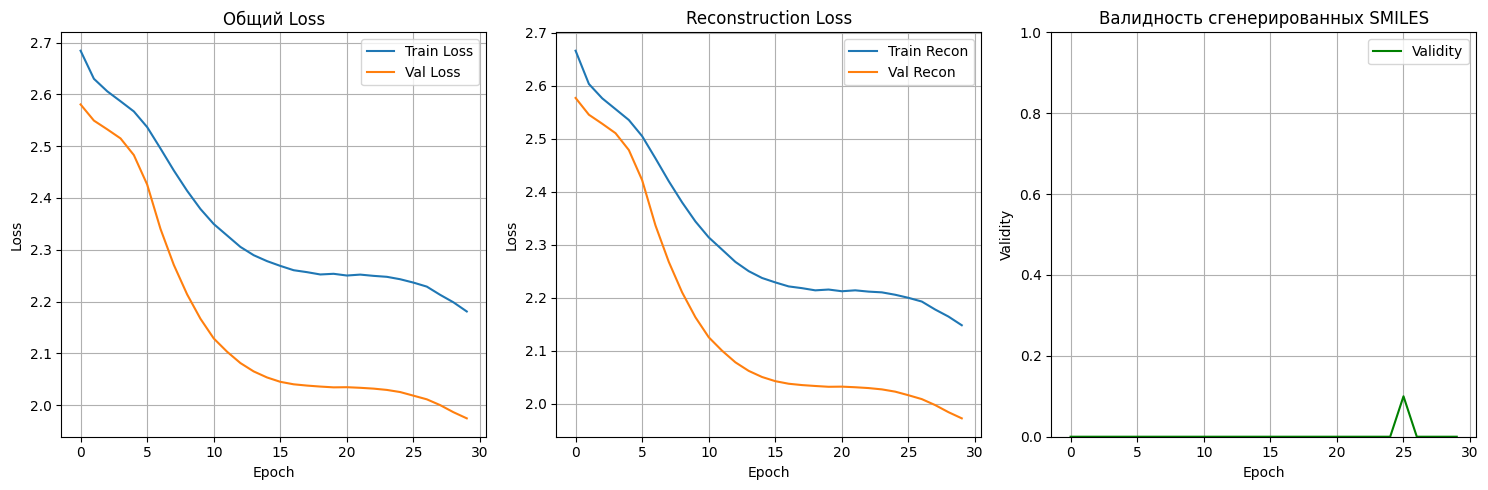

In [19]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Общий Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(train_recon, label='Train Recon')
plt.plot(val_recon, label='Val Recon')
plt.title('Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(validities, label='Validity', color='green')
plt.title('Валидность сгенерированных SMILES')
plt.xlabel('Epoch')
plt.ylabel('Validity')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [20]:
# Финальное сохранение
torch.save(model.state_dict(), "improved_transformer_smiles_conditional.pth")
print("Модель сохранена!")

Модель сохранена!


In [ ]:
# Тестирование финальной модели
print("Финальная генерация:")
sample_feats = torch.tensor(val_df[NUM_FEATURES].iloc[:3].values, dtype=torch.float32).to(device)  # ← ДОБАВЬТЕ .to(device)
generate_and_display_improved(model, sample_feats, num_samples=6, temperature=0.8)

In [ ]:
#
# Тестирование с разными температурами
print("=== Генерация с разными температурами ===")

sample_feats = torch.tensor(val_df[NUM_FEATURES].iloc[:1].values, dtype=torch.float32).to(device)

for temp in [0.5, 0.7, 0.9, 1.1]:
    print(f"\n--- Температура: {temp} ---")
    smiles_list, valid_smiles = generate_and_display_improved(model, sample_feats, num_samples=5, temperature=temp)

In [ ]:

print("=== ТЕСТИРОВАНИЕ УЛУЧШЕННОЙ ГЕНЕРАЦИИ ===")

# Тестируем на разных примерах
sample_indices = [0, 10, 50]  # разные молекулы из валидационного набора
for idx in sample_indices:
    print(f"\n--- Пример {idx} ---")
    sample_feats = torch.tensor(val_df[NUM_FEATURES].iloc[idx:idx+1].values, dtype=torch.float32).to(device)
    
    # Оригинальная молекула
    original_smiles = val_df.iloc[idx]["polymer_smiles"]
    print(f"Оригинальная SMILES: {original_smiles}")
    print(f"Валидность оригинала: {'✓' if is_valid_smiles(original_smiles) else '✗'}")
    
    # Генерация с улучшенным методом
    validity_rate = generate_and_display_improved(model, sample_feats, num_samples=6, temperature=0.7)
    print(f"Процент валидности: {validity_rate:.1%}")

In [ ]:
# Загрузка лучшей модели для инференса
def load_best_model():
    checkpoint = torch.load(os.path.join(CHECKPOINT_DIR, 'best_model.pth'))
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Загружена лучшая модель с эпохи {checkpoint['epoch']}, val_loss: {checkpoint['val_loss']:.4f}")
    return model

In [ ]:
# Загрузка если нужно
# model = load_best_model()